In [159]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch

import renyi
import utils
import sxp

from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Entropy on a metric space with two points

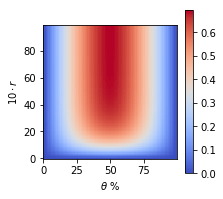

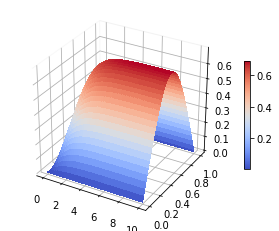

In [71]:
rs = np.linspace(0, 10, 100)
thetas = np.linspace(0, 1, 100)

res = np.zeros((len(rs), len(theta)))
for i, r_val in enumerate(rs):
    for j, theta_val in enumerate(thetas):
        K = torch.tensor([[1, np.exp(-r_val)],
                          [np.exp(-r_val), 1]])
        p = torch.tensor([[theta_val, 1-theta_val]])
        res[i, j] = renyi.renyi_sim_entropy(K, p, 2)
        
        
fig = plt.figure(figsize=(3, 3))
s = fig.add_subplot(1, 1, 1, xlabel='$\\theta$ %', ylabel='$10 \cdot r$')
im = s.imshow(res, origin='lower', cmap=cm.coolwarm)
plt.grid(False)
fig.colorbar(im)
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = fig.gca(projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
X, Y = np.meshgrid(thetas, rs)
surf = ax.plot_surface(Y, X, res, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=20)
plt.show()

### Finding a MaxEnt distribution with gradient descent

K det 3.26947e-13 - K rank 200
3.1240


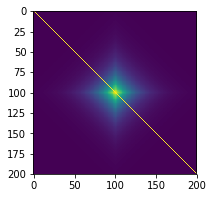

In [165]:
alpha = 2

n = 200
K = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        K[i, j] = 1.0 * (i==j) + 1.0 * (i!=j) *np.exp(-0.05*(np.abs(i-n/2) + np.abs(j-n/2))) 
print('K det %.5e - K rank %d' % (np.linalg.det(K), np.linalg.matrix_rank(K)))
K = torch.Tensor(K)

plt.figure(figsize=(3, 3))
plt.imshow(K);

logit_p = torch.nn.Parameter(0*torch.Tensor(np.random.rand(1, n)))
optimizer = torch.optim.Adam([logit_p], lr=0.02)

p = torch.softmax(logit_p, dim=1)
loss = - renyi.renyi_sim_entropy(K, p, alpha)
print("%.4f" % (-loss.item()))

0 - 3.1240
500 - 4.6177
1000 - 4.6263
1500 - 4.6286
Elapsed time:  0.8749935626983643


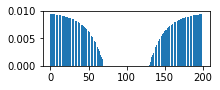

In [166]:
start = time()

for _ in range(2000):
    
    optimizer.zero_grad()
    p = torch.softmax(logit_p, dim=1)
    loss = - renyi.renyi_sim_entropy(K, p, alpha)

    if _ % 500 == 0:
        print("%d - %.4f" % (_, -loss.item()))

    loss.backward()
    optimizer.step()

print('Elapsed time: ', time()-start)

p = torch.softmax(logit_p, dim=1)
plt.figure(figsize=(3, 1))
plt.bar(range(n), p.data.squeeze().numpy());

### Minimizing divergence between empirical distributions on a metric space

In [216]:
Y[torch.tensor(np.random.choice(range(m), n))]

RuntimeError: tensors used as indices must be long or byte tensors

tensor([ 8, 10,  3, 11,  8,  3,  2,  8, 12,  7,  5,  0, 14,  1, 11])

torch.Size([15, 2])

In [229]:
alpha = 10

n, m, d = 15, 15, 2

kernel = lambda x, y: renyi.generic_kernel(x, y, lambda u, v: renyi.poly_kernel(u, v, 1.3))

p = torch.Tensor(np.random.dirichlet((np.ones(m)), 1))
Y = torch.Tensor(np.random.multivariate_normal(np.zeros(d), np.eye(d), m))

logit_q = torch.nn.Parameter(torch.Tensor(np.random.rand(1, n)))
X = torch.nn.Parameter(Y[torch.randint(m, (n, 1)).squeeze(), ...])
#X = torch.nn.Parameter(torch.Tensor(np.random.multivariate_normal(np.zeros(d), np.eye(d), n)))

optimizer = torch.optim.Adam([logit_q, X], lr=0.01)

0 - 0.0027
250 - 0.0024
500 - 0.0025
750 - 0.0024


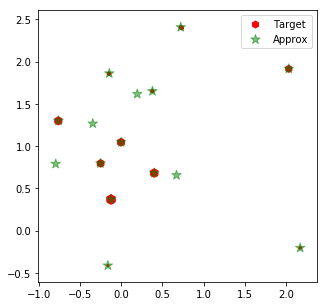

In [234]:
for _ in range(1000):
    
    optimizer.zero_grad()
    q = torch.softmax(logit_q, dim=1)
    loss = renyi.renyi_mixture_divergence(p, Y, q, X, kernel, alpha, use_avg=False)
    
    if _ % 250 == 0:
        print("%d - %.4f" % (_, loss.item()))

    loss.backward()
    optimizer.step()

q = torch.softmax(logit_q, dim=0)

plt.figure(figsize=(5,5))
plt.scatter(X.data.numpy()[:, 0], X.data.numpy()[:, 1], s=list(500*p.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=1)
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(100*q.data.squeeze().numpy()), label='Approx', marker='*', c='g', alpha=0.5)
plt.legend(loc='best');